In [82]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import tempfile
import shutil

# Dataset configuration
CLASSES = ['cloudy', 'land', 'water']
DATA_DIR = 'data'

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, is_training=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_training = is_training
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize to 64x64
            image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC)
                
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Fallback to black image
            image = np.zeros((64, 64, 3), dtype=np.uint8)
        
        if self.transform:
            if isinstance(self.transform, A.Compose):
                transformed = self.transform(image=image)
                image = transformed['image']
            else:
                image = self.transform(image)
            
        return image, self.labels[idx]

class ImageClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super().__init__()
        
        # Simple CNN for 64x64 images
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8x8
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def load_data(data_dir):
    """Load images and labels from directory structure"""
    image_paths = []
    labels = []
    
    print(f"Loading data from {data_dir}...")
    
    for class_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist")
            continue
            
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
        class_images = 0
        
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(valid_extensions):
                image_path = os.path.join(class_dir, filename)
                # Quick validation
                test_img = cv2.imread(image_path)
                if test_img is not None:
                    image_paths.append(image_path)
                    labels.append(class_idx)
                    class_images += 1
        
        print(f"  {class_name}: {class_images} images")
    
    print(f"Total: {len(image_paths)} images across {len(set(labels))} classes")
    return image_paths, labels

def get_transforms():
    """Get transforms for 64x64 images"""
    
    train_transform = A.Compose([
        A.Resize(height=64, width=64),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.3),
        # A.ColorJitter(),
        A.RandomBrightnessContrast(),
        A.HueSaturationValue(),
        A.RGBShift(r_shift_limit=0, g_shift_limit=0, b_shift_limit=90, p=0.8),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    val_transform = A.Compose([
        A.Resize(height=64, width=64),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, num_epochs=25, patience=10):
    """Training loop"""
    
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    
    print(f"Training on {device}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_acc = train_correct / train_total
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{train_acc:.4f}'})
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')
        
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_acc = correct / total
                val_pbar.set_postfix({'Acc': f'{val_acc:.4f}'})
        
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        
        # Update scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  → New best validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"  → No improvement. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print("-" * 50)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    
    return history

def test_image(image_path, model_path='image_classifier_64x64.pth', show_plots=True):
    """
    Test a single 64x64 image (or resize to 64x64).
    Simple single-pass classification.
    """
    
    # Set device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model = ImageClassifier(num_classes=len(CLASSES))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    
    # Get validation transform
    _, val_transform = get_transforms()
    
    # Transform image
    image_tensor = val_transform(image=image)['image'].unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        pred_class = CLASSES[predicted.item()]
        conf_score = confidence.item()
        all_probs = probabilities.cpu().numpy()[0]
    
    if show_plots:
        print(f"Predicted Class: {pred_class}")
        print(f"Confidence: {conf_score:.4f}")
        print(f"All probabilities: {dict(zip(CLASSES, all_probs))}")
        
        # Show image
        plt.figure(figsize=(8, 6))
        plt.imshow(original_image)
        plt.title(f"Prediction: {pred_class} (Confidence: {conf_score:.3f})")
        plt.axis('off')
        plt.show()
    
    return pred_class, conf_score

def test_large_image(image_path, tile_size=64, overlap=0.0, confidence_threshold=0.5, 
                     model_path='image_classifier_64x64.pth', visualize=True, darkness_threshold=30):
    """
    Test a large image by dividing it into tiles and running test_image on each tile.
    If a tile is too dark, classify it as space instead.
    """
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    h, w = image.shape[:2]
    
    step_size = int(tile_size * (1 - overlap))
    
    # Data structures for analysis
    class_counts = defaultdict(int)
    class_confidences = defaultdict(list)
    tile_details = []
    
    # Define colors for visualization
    class_colors = {
        'cloudy': (255, 150, 150),
        'land': (150, 255, 150),    
        'water': (150, 150, 255),
        'space': (50, 50, 50)  # Dark gray for space
    }
    
    print(f"Processing {h}x{w} image with {tile_size}x{tile_size} tiles...")
    print(f"Darkness threshold: {darkness_threshold} (tiles darker than this will be classified as space)")
    
    # Create temporary directory for tile images
    temp_dir = tempfile.mkdtemp()
    
    try:
        total_tiles = 0
        confident_tiles = 0
        
        for y in range(0, h - tile_size + 1, step_size):
            for x in range(0, w - tile_size + 1, step_size):
                total_tiles += 1
                
                # Extract tile
                tile = image[y:y+tile_size, x:x+tile_size]
                
                # Check if tile is too dark
                mean_brightness = np.mean(tile)
                
                if mean_brightness < darkness_threshold:
                    # Classify as space
                    tile_class = 'space'
                    tile_confidence = 1.0  # High confidence for space classification
                    confident_tiles += 1
                    class_counts[tile_class] += 1
                    class_confidences[tile_class].append(tile_confidence)
                    tile_details.append((x, y, tile_class, tile_confidence))
                else:
                    # Save tile temporarily and process with model
                    tile_path = os.path.join(temp_dir, f"tile_{total_tiles}.jpg")
                    tile_bgr = cv2.cvtColor(tile, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(tile_path, tile_bgr)
                    
                    try:
                        # Use test_image on this tile (no plots)
                        tile_class, tile_confidence = test_image(
                            tile_path, 
                            model_path=model_path, 
                            show_plots=False
                        )
                        
                        if tile_class is not None and tile_confidence >= confidence_threshold:
                            confident_tiles += 1
                            class_counts[tile_class] += 1
                            class_confidences[tile_class].append(tile_confidence)
                            tile_details.append((x, y, tile_class, tile_confidence))
                        
                    except Exception as e:
                        print(f"Error processing tile at ({x}, {y}): {e}")
                        continue
                    
                    # Clean up tile file
                    if os.path.exists(tile_path):
                        os.remove(tile_path)
    
    finally:
        # Clean up temp directory
        shutil.rmtree(temp_dir, ignore_errors=True)
    
    if confident_tiles == 0:
        print("No confident tiles found.")
        return {}, 0.0, "Unclassifiable"
    
    # Calculate comprehensive statistics (including space)
    total_confident = sum(class_counts.values())
    all_classes = list(CLASSES) + ['space']
    
    results = {}
    for class_name in all_classes:
        count = class_counts[class_name]
        if count > 0:
            avg_confidence = np.mean(class_confidences[class_name])
            percentage = 100 * count / total_confident
            results[class_name] = {
                'count': count,
                'percentage': percentage,
                'avg_confidence': avg_confidence,
                'total_coverage': 100 * count / total_tiles
            }
        else:
            results[class_name] = {
                'count': 0,
                'percentage': 0.0,
                'avg_confidence': 0.0,
                'total_coverage': 0.0
            }
    
    # Find dominant class
    dominant_class = max(class_counts, key=class_counts.get)
    
    # Calculate overall confidence as weighted average
    total_confidence_sum = sum(
        count * np.mean(confidences) 
        for count, confidences in zip(class_counts.values(), class_confidences.values())
        if count > 0
    )
    overall_confidence = total_confidence_sum / total_confident
    
    # Print results
    print(f"\n=== LARGE IMAGE ANALYSIS RESULTS ===")
    print(f"Image Size: {h}x{w} pixels")
    print(f"Total Tiles: {total_tiles}")
    print(f"Confident Tiles: {confident_tiles} ({100*confident_tiles/total_tiles:.1f}%)")
    print(f"Tile Size: {tile_size}x{tile_size}")
    print(f"Confidence Threshold: {confidence_threshold:.2f}")
    
    print(f"\n--- CLASS DISTRIBUTION ---")
    for class_name in sorted(results.keys()):
        r = results[class_name]
        if r['count'] > 0:
            print(f"{class_name:10s}: {r['count']:4d} tiles ({r['percentage']:5.1f}%) "
                  f"- Avg Conf: {r['avg_confidence']:.3f}")
    
    print(f"\nDominant Class: {dominant_class}")
    print(f"Overall Confidence: {overall_confidence:.4f}")
    
    # Determine image type
    if len([c for c in class_counts.values() if c > 0]) == 1:
        image_type = f"Homogeneous ({dominant_class})"
    else:
        sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
        image_type = "Mixed: " + ", ".join([f"{name} ({results[name]['percentage']:.0f}%)" 
                                          for name, count in sorted_classes if count > 0])
    
    print(f"Image Type: {image_type}")
    
    # Visualization
    if visualize and confident_tiles > 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        
        # Original image
        ax1.imshow(original_image)
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        # Classified tiles
        overlay_image = original_image.copy()
        for x, y, pred_class, conf_score in tile_details:
            color = class_colors.get(pred_class, (255, 255, 255))
            thickness = max(1, int(conf_score * 4))
            cv2.rectangle(overlay_image, (x, y), (x + tile_size, y + tile_size), color, thickness)
        
        ax2.imshow(overlay_image)
        ax2.set_title(f"Tile Classifications\n({confident_tiles}/{total_tiles} confident)")
        ax2.axis('off')
        
        # Class distribution pie chart
        if total_confident > 0:
            class_names = [name for name in class_counts.keys() if class_counts[name] > 0]
            class_values = [class_counts[name] for name in class_names]
            colors_pie = [np.array(class_colors[name])/255.0 for name in class_names]
            
            ax3.pie(class_values, labels=class_names, colors=colors_pie, autopct='%1.1f%%')
            ax3.set_title("Class Distribution")
        
        plt.tight_layout()
        plt.show()
    
    return results, overall_confidence, image_type

def main():
    # Configuration
    config = {
        'batch_size': 30,
        'num_epochs': 50,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'dropout_rate': 0.3,
        'patience': 20,
    }
    
    # Set device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    print(f"Using device: {device}")
    
    # Load data
    image_paths, labels = load_data(DATA_DIR)
    
    if len(image_paths) == 0:
        print("No images found. Check your data directory structure.")
        return
    
    # Split data
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=0.4, random_state=42, stratify=labels
    )
    
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    print(f"\nData split:")
    print(f"Training: {len(train_paths)} images")
    print(f"Validation: {len(val_paths)} images") 
    print(f"Test: {len(test_paths)} images")
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = ImageDataset(train_paths, train_labels, train_transform)
    val_dataset = ImageDataset(val_paths, val_labels, val_transform)
    test_dataset = ImageDataset(test_paths, test_labels, val_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                           shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                            shuffle=False, num_workers=0)
    
    # Initialize model
    model = ImageClassifier(num_classes=len(CLASSES), 
                           dropout_rate=config['dropout_rate'])
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], 
                          weight_decay=config['weight_decay'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                         scheduler, device, config['num_epochs'], config['patience'])
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': CLASSES,
        'config': config,
        'history': history
    }, 'image_classifier_64x64.pth')
    print("Model saved to image_classifier_64x64.pth")

if __name__ == "__main__":
    main()

Using device: mps
Loading data from data...
  cloudy: 1500 images
  land: 2631 images
  water: 1500 images
Total: 5631 images across 3 classes

Data split:
Training: 3378 images
Validation: 1126 images
Test: 1127 images
Model parameters: 2,554,115
Training on mps
Training samples: 3378
Validation samples: 1126
--------------------------------------------------


Epoch 1/50 [Train]: 100%|█| 113/113 [00:04<00:00, 23.93it
Epoch 1/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.18it/s
/Users/mars/space-engineering-final/venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Train Loss: 0.7263, Train Acc: 0.6231, Val Loss: 0.6156, Val Acc: 0.7096, LR: 0.001000
  → New best validation accuracy: 0.7096
--------------------------------------------------


Epoch 2/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.56it
Epoch 2/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.08it/s


Epoch 2: Train Loss: 0.6882, Train Acc: 0.6368, Val Loss: 0.5304, Val Acc: 0.6918, LR: 0.001000
  → No improvement. Patience: 1/20
--------------------------------------------------


Epoch 3/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.30it
Epoch 3/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.17it/s


Epoch 3: Train Loss: 0.6462, Train Acc: 0.6652, Val Loss: 0.5216, Val Acc: 0.7380, LR: 0.001000
  → New best validation accuracy: 0.7380
--------------------------------------------------


Epoch 4/50 [Train]: 100%|█| 113/113 [00:04<00:00, 24.89it
Epoch 4/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 51.60it/s


Epoch 4: Train Loss: 0.6415, Train Acc: 0.6646, Val Loss: 0.4855, Val Acc: 0.7584, LR: 0.001000
  → New best validation accuracy: 0.7584
--------------------------------------------------


Epoch 5/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.58it
Epoch 5/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.87it/s


Epoch 5: Train Loss: 0.6377, Train Acc: 0.6655, Val Loss: 0.5110, Val Acc: 0.8011, LR: 0.001000
  → New best validation accuracy: 0.8011
--------------------------------------------------


Epoch 6/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.42it
Epoch 6/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.77it/s


Epoch 6: Train Loss: 0.6293, Train Acc: 0.6758, Val Loss: 0.4646, Val Acc: 0.7744, LR: 0.001000
  → No improvement. Patience: 1/20
--------------------------------------------------


Epoch 7/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.49it
Epoch 7/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.56it/s


Epoch 7: Train Loss: 0.6152, Train Acc: 0.6779, Val Loss: 0.4897, Val Acc: 0.7638, LR: 0.001000
  → No improvement. Patience: 2/20
--------------------------------------------------


Epoch 8/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.50it
Epoch 8/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.33it/s


Epoch 8: Train Loss: 0.6383, Train Acc: 0.6670, Val Loss: 0.5582, Val Acc: 0.6314, LR: 0.001000
  → No improvement. Patience: 3/20
--------------------------------------------------


Epoch 9/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.54it
Epoch 9/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.99it/s


Epoch 9: Train Loss: 0.6542, Train Acc: 0.6607, Val Loss: 0.5597, Val Acc: 0.7016, LR: 0.001000
  → No improvement. Patience: 4/20
--------------------------------------------------


Epoch 10/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.45i
Epoch 10/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.37it/


Epoch 10: Train Loss: 0.6430, Train Acc: 0.6693, Val Loss: 0.4753, Val Acc: 0.7638, LR: 0.001000
  → No improvement. Patience: 5/20
--------------------------------------------------


Epoch 11/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.55i
Epoch 11/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.49it/


Epoch 11: Train Loss: 0.6232, Train Acc: 0.6649, Val Loss: 0.4986, Val Acc: 0.7940, LR: 0.001000
  → No improvement. Patience: 6/20
--------------------------------------------------


Epoch 12/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.20i
Epoch 12/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.40it/


Epoch 12: Train Loss: 0.6148, Train Acc: 0.6824, Val Loss: 0.4524, Val Acc: 0.7735, LR: 0.001000
  → No improvement. Patience: 7/20
--------------------------------------------------


Epoch 13/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.41i
Epoch 13/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.22it/


Epoch 13: Train Loss: 0.6181, Train Acc: 0.6755, Val Loss: 0.4887, Val Acc: 0.7531, LR: 0.001000
  → No improvement. Patience: 8/20
--------------------------------------------------


Epoch 14/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.19i
Epoch 14/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.23it/


Epoch 14: Train Loss: 0.6036, Train Acc: 0.6871, Val Loss: 0.4459, Val Acc: 0.7735, LR: 0.001000
  → No improvement. Patience: 9/20
--------------------------------------------------


Epoch 15/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.39i
Epoch 15/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.83it/


Epoch 15: Train Loss: 0.6243, Train Acc: 0.6764, Val Loss: 0.5098, Val Acc: 0.7140, LR: 0.001000
  → No improvement. Patience: 10/20
--------------------------------------------------


Epoch 16/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.43i
Epoch 16/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.72it/


Epoch 16: Train Loss: 0.6159, Train Acc: 0.6764, Val Loss: 0.4639, Val Acc: 0.7664, LR: 0.001000
  → No improvement. Patience: 11/20
--------------------------------------------------


Epoch 17/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.59i
Epoch 17/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.34it/


Epoch 17: Train Loss: 0.6263, Train Acc: 0.6625, Val Loss: 0.4775, Val Acc: 0.7629, LR: 0.001000
  → No improvement. Patience: 12/20
--------------------------------------------------


Epoch 18/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.56i
Epoch 18/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.77it/


Epoch 18: Train Loss: 0.6087, Train Acc: 0.6699, Val Loss: 0.4701, Val Acc: 0.7442, LR: 0.001000
  → No improvement. Patience: 13/20
--------------------------------------------------


Epoch 19/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.58i
Epoch 19/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.49it/


Epoch 19: Train Loss: 0.6140, Train Acc: 0.6773, Val Loss: 0.4668, Val Acc: 0.7815, LR: 0.001000
  → No improvement. Patience: 14/20
--------------------------------------------------


Epoch 20/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.58i
Epoch 20/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.20it/


Epoch 20: Train Loss: 0.6374, Train Acc: 0.6548, Val Loss: 0.4660, Val Acc: 0.7567, LR: 0.001000
  → No improvement. Patience: 15/20
--------------------------------------------------


Epoch 21/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.58i
Epoch 21/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.61it/


Epoch 21: Train Loss: 0.6089, Train Acc: 0.6859, Val Loss: 0.4318, Val Acc: 0.8179, LR: 0.001000
  → New best validation accuracy: 0.8179
--------------------------------------------------


Epoch 22/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.25i
Epoch 22/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.67it/


Epoch 22: Train Loss: 0.5967, Train Acc: 0.6871, Val Loss: 0.4423, Val Acc: 0.7940, LR: 0.001000
  → No improvement. Patience: 1/20
--------------------------------------------------


Epoch 23/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.57i
Epoch 23/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.84it/


Epoch 23: Train Loss: 0.6057, Train Acc: 0.6892, Val Loss: 0.4594, Val Acc: 0.8277, LR: 0.001000
  → New best validation accuracy: 0.8277
--------------------------------------------------


Epoch 24/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.58i
Epoch 24/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.24it/


Epoch 24: Train Loss: 0.5904, Train Acc: 0.6951, Val Loss: 0.4949, Val Acc: 0.7043, LR: 0.001000
  → No improvement. Patience: 1/20
--------------------------------------------------


Epoch 25/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.53i
Epoch 25/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.03it/


Epoch 25: Train Loss: 0.5662, Train Acc: 0.7490, Val Loss: 0.5127, Val Acc: 0.7762, LR: 0.001000
  → No improvement. Patience: 2/20
--------------------------------------------------


Epoch 26/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.59i
Epoch 26/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.80it/


Epoch 26: Train Loss: 0.5233, Train Acc: 0.7691, Val Loss: 0.2676, Val Acc: 0.9050, LR: 0.001000
  → New best validation accuracy: 0.9050
--------------------------------------------------


Epoch 27/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.46i
Epoch 27/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.23it/


Epoch 27: Train Loss: 0.4820, Train Acc: 0.8058, Val Loss: 0.2368, Val Acc: 0.9130, LR: 0.001000
  → New best validation accuracy: 0.9130
--------------------------------------------------


Epoch 28/50 [Train]: 100%|█| 113/113 [00:04<00:00, 24.93i
Epoch 28/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.06it/


Epoch 28: Train Loss: 0.4357, Train Acc: 0.8171, Val Loss: 0.1974, Val Acc: 0.9485, LR: 0.001000
  → New best validation accuracy: 0.9485
--------------------------------------------------


Epoch 29/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.17i
Epoch 29/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.64it/


Epoch 29: Train Loss: 0.4214, Train Acc: 0.8384, Val Loss: 0.2637, Val Acc: 0.9227, LR: 0.001000
  → No improvement. Patience: 1/20
--------------------------------------------------


Epoch 30/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.47i
Epoch 30/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.05it/


Epoch 30: Train Loss: 0.4316, Train Acc: 0.8330, Val Loss: 0.4502, Val Acc: 0.8144, LR: 0.001000
  → No improvement. Patience: 2/20
--------------------------------------------------


Epoch 31/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.61i
Epoch 31/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.97it/


Epoch 31: Train Loss: 0.3722, Train Acc: 0.8552, Val Loss: 0.2672, Val Acc: 0.8783, LR: 0.001000
  → No improvement. Patience: 3/20
--------------------------------------------------


Epoch 32/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.38i
Epoch 32/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.01it/


Epoch 32: Train Loss: 0.3754, Train Acc: 0.8499, Val Loss: 0.2206, Val Acc: 0.9139, LR: 0.001000
  → No improvement. Patience: 4/20
--------------------------------------------------


Epoch 33/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.66i
Epoch 33/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.60it/


Epoch 33: Train Loss: 0.3411, Train Acc: 0.8706, Val Loss: 0.2777, Val Acc: 0.9094, LR: 0.001000
  → No improvement. Patience: 5/20
--------------------------------------------------


Epoch 34/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.10i
Epoch 34/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.50it/


Epoch 34: Train Loss: 0.3623, Train Acc: 0.8546, Val Loss: 0.2945, Val Acc: 0.8694, LR: 0.001000
  → No improvement. Patience: 6/20
--------------------------------------------------


Epoch 35/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.18i
Epoch 35/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.66it/


Epoch 35: Train Loss: 0.3532, Train Acc: 0.8591, Val Loss: 0.1546, Val Acc: 0.9343, LR: 0.001000
  → No improvement. Patience: 7/20
--------------------------------------------------


Epoch 36/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.51i
Epoch 36/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.90it/


Epoch 36: Train Loss: 0.3442, Train Acc: 0.8724, Val Loss: 0.1690, Val Acc: 0.9485, LR: 0.001000
  → No improvement. Patience: 8/20
--------------------------------------------------


Epoch 37/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.46i
Epoch 37/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 57.50it/


Epoch 37: Train Loss: 0.3322, Train Acc: 0.8745, Val Loss: 0.1408, Val Acc: 0.9618, LR: 0.001000
  → New best validation accuracy: 0.9618
--------------------------------------------------


Epoch 38/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.26i
Epoch 38/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.02it/


Epoch 38: Train Loss: 0.3536, Train Acc: 0.8680, Val Loss: 0.1888, Val Acc: 0.9449, LR: 0.001000
  → No improvement. Patience: 1/20
--------------------------------------------------


Epoch 39/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.57i
Epoch 39/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.72it/


Epoch 39: Train Loss: 0.3134, Train Acc: 0.8798, Val Loss: 0.2853, Val Acc: 0.9041, LR: 0.001000
  → No improvement. Patience: 2/20
--------------------------------------------------


Epoch 40/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.53i
Epoch 40/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.63it/


Epoch 40: Train Loss: 0.3157, Train Acc: 0.8777, Val Loss: 0.2701, Val Acc: 0.8979, LR: 0.001000
  → No improvement. Patience: 3/20
--------------------------------------------------


Epoch 41/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.46i
Epoch 41/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.38it/


Epoch 41: Train Loss: 0.2984, Train Acc: 0.8848, Val Loss: 0.2177, Val Acc: 0.9121, LR: 0.001000
  → No improvement. Patience: 4/20
--------------------------------------------------


Epoch 42/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.50i
Epoch 42/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 57.47it/


Epoch 42: Train Loss: 0.3175, Train Acc: 0.8801, Val Loss: 0.1449, Val Acc: 0.9556, LR: 0.001000
  → No improvement. Patience: 5/20
--------------------------------------------------


Epoch 43/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.32i
Epoch 43/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.75it/


Epoch 43: Train Loss: 0.3287, Train Acc: 0.8650, Val Loss: 0.1555, Val Acc: 0.9600, LR: 0.001000
  → No improvement. Patience: 6/20
--------------------------------------------------


Epoch 44/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.56i
Epoch 44/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.50it/


Epoch 44: Train Loss: 0.3077, Train Acc: 0.8828, Val Loss: 0.1662, Val Acc: 0.9538, LR: 0.001000
  → No improvement. Patience: 7/20
--------------------------------------------------


Epoch 45/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.61i
Epoch 45/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.58it/


Epoch 45: Train Loss: 0.3200, Train Acc: 0.8724, Val Loss: 0.1649, Val Acc: 0.9520, LR: 0.001000
  → No improvement. Patience: 8/20
--------------------------------------------------


Epoch 46/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.41i
Epoch 46/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.99it/


Epoch 46: Train Loss: 0.3005, Train Acc: 0.8792, Val Loss: 0.1134, Val Acc: 0.9645, LR: 0.001000
  → New best validation accuracy: 0.9645
--------------------------------------------------


Epoch 47/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.39i
Epoch 47/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.73it/


Epoch 47: Train Loss: 0.2866, Train Acc: 0.8893, Val Loss: 0.1702, Val Acc: 0.9218, LR: 0.001000
  → No improvement. Patience: 1/20
--------------------------------------------------


Epoch 48/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.62i
Epoch 48/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 57.04it/


Epoch 48: Train Loss: 0.3049, Train Acc: 0.8860, Val Loss: 0.2177, Val Acc: 0.8890, LR: 0.001000
  → No improvement. Patience: 2/20
--------------------------------------------------


Epoch 49/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.58i
Epoch 49/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 56.07it/


Epoch 49: Train Loss: 0.2788, Train Acc: 0.8943, Val Loss: 0.1275, Val Acc: 0.9618, LR: 0.001000
  → No improvement. Patience: 3/20
--------------------------------------------------


Epoch 50/50 [Train]: 100%|█| 113/113 [00:04<00:00, 25.39i
Epoch 50/50 [Valid]: 100%|█| 38/38 [00:00<00:00, 55.48it/


Epoch 50: Train Loss: 0.3050, Train Acc: 0.8896, Val Loss: 0.1328, Val Acc: 0.9600, LR: 0.001000
  → No improvement. Patience: 4/20
--------------------------------------------------
Loaded best model with validation accuracy: 0.9645
Model saved to image_classifier_64x64.pth


Processing 240x320 image with 64x64 tiles...
Darkness threshold: 30 (tiles darker than this will be classified as space)

=== LARGE IMAGE ANALYSIS RESULTS ===
Image Size: 240x320 pixels
Total Tiles: 24
Confident Tiles: 24 (100.0%)
Tile Size: 64x64
Confidence Threshold: 0.50

--- CLASS DISTRIBUTION ---
cloudy    :   16 tiles ( 66.7%) - Avg Conf: 0.966
water     :    8 tiles ( 33.3%) - Avg Conf: 0.820

Dominant Class: cloudy
Overall Confidence: 0.9174
Image Type: Mixed: cloudy (67%), water (33%)


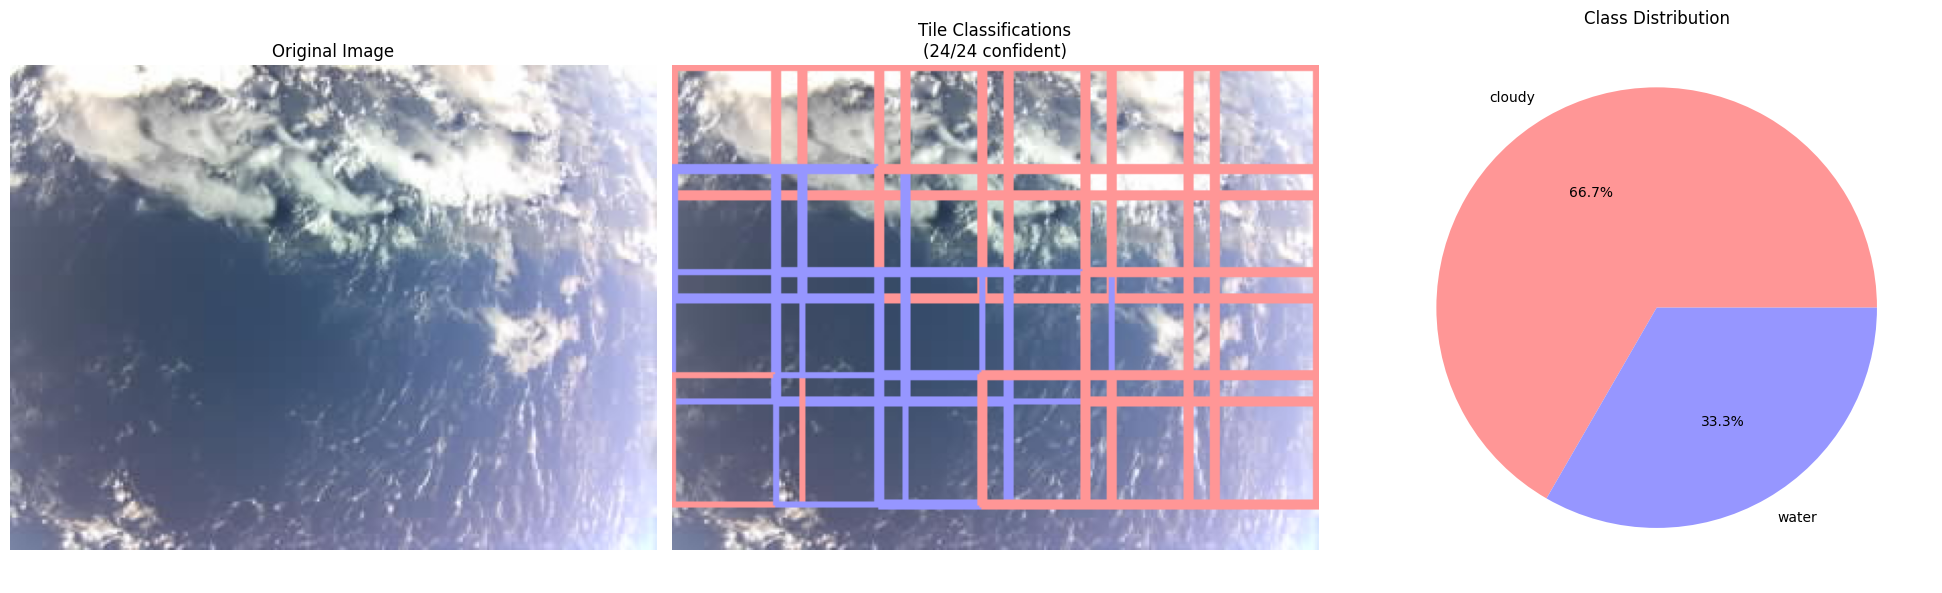

In [103]:
custom_image_path = "ER_Earth_40/B3_ER_IMG_26.jpg"
results, confidence, image_type = test_large_image(
    image_path=custom_image_path,
    tile_size=64,                    # Size of each tile (64x64 pixels)
    overlap=0.2,                     # 20% overlap between tiles
    confidence_threshold=0.5,        # Only count tiles with >50% confidence
    model_path='image_classifier_64x64.pth',  # Path to your trained model
    visualize=True,                   # Show visualization plots
    darkness_threshold=30,
)
